# Model Comparison & Correlation Analysis

**Obiettivo:** Confronto completo di tutti i modelli addestrati e analisi di correlazione tra le loro predizioni

**Modelli analizzati:**
1. **XGBoost** (multi-class: BP/FP/TP)
2. **XGBoost_v2** (binary: Non-TP vs TP)
3. **Random Forest** (multi-class: BP/FP/TP)

**Analisi:**
1. Confronto metriche (Accuracy, F1, ROC AUC)
2. Visualizzazione comparativa
3. Matrice di correlazione tra predizioni
4. Agreement analysis (dove i modelli concordano/discordano)
5. Feature importance comparison

## 1. Setup

In [23]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerie importate con successo!")

✅ Librerie importate con successo!


## 2. Caricamento Metriche Salvate

In [24]:
# Carica metriche JSON
models_dir = Path('../models')

metrics = {}

# Carica tutte le metriche disponibili
model_paths = {
    'XGBoost (multi)': 'xgboost',
    'XGBoost_v2 (binary)': 'xgboost_v2',
    'XGBoost_SMOTE (binary)': 'xgboost_smote',
    'Random Forest (multi)': 'random_forest',
    'MLP Baseline': 'mlp_baseline',
    'MLP Undersampling': 'mlp_undersampling'
}

print("Caricamento metriche...\n")
for model_name, model_path in model_paths.items():
    metrics_file = models_dir / model_path / 'metrics.json'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            metrics[model_name] = json.load(f)
        print(f"✅ {model_name:30s} - {metrics[model_name]['timestamp'][:10]}")
    else:
        print(f"⚠️  {model_name:30s} - File non trovato")

print(f"\n{len(metrics)} modelli caricati con successo!")

Caricamento metriche...

✅ XGBoost (multi)                - 2025-10-29
✅ XGBoost_v2 (binary)            - 2025-10-30
✅ XGBoost_SMOTE (binary)         - 2025-10-30
✅ Random Forest (multi)          - 2025-10-29
✅ MLP Baseline                   - 2025-10-30
✅ MLP Undersampling              - 2025-10-30

6 modelli caricati con successo!


## 3. Confronto Metriche Generali

In [25]:
# Helper function per estrarre metriche (gestisce differenze tra multi-class e binary)
def get_metric(model_metrics, metric_name):
    """Estrae una metrica, gestendo nomi diversi tra modelli"""
    # Mapping dei nomi delle metriche
    metric_mappings = {
        'accuracy': ['test_accuracy', 'accuracy'],
        'f1': ['test_macro_f1', 'test_f1_score', 'f1_score'],
        'precision': ['test_precision', 'precision'],
        'recall': ['test_recall', 'recall'],
        'roc_auc': ['roc_auc_micro', 'test_roc_auc', 'roc_auc']
    }
    
    # Prova le diverse chiavi possibili
    test_metrics = model_metrics.get('test_metrics', {})
    
    for possible_key in metric_mappings.get(metric_name, [metric_name]):
        if possible_key in model_metrics:
            return model_metrics[possible_key]
        if possible_key in test_metrics:
            return test_metrics[possible_key]
    
    return None

# Crea DataFrame per confronto
comparison_data = {
    'Model': [],
    'Type': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC AUC': [],
    'N Features': [],
    'Train Samples': [],
    'Test Samples': []
}

for model_name, model_metrics in metrics.items():
    comparison_data['Model'].append(model_name)
    
    # Determina tipo e dataset
    if 'multi' in model_name:
        comparison_data['Type'].append('Multi-class')
        comparison_data['Dataset'].append('v1 (processed)')
    elif 'MLP' in model_name:
        comparison_data['Type'].append('Binary')
        comparison_data['Dataset'].append('v3_balanced')
    else:
        comparison_data['Type'].append('Binary')
        comparison_data['Dataset'].append('v3 (processed_v3)')
    
    # Estrai metriche
    comparison_data['Accuracy'].append(get_metric(model_metrics, 'accuracy'))
    comparison_data['Precision'].append(get_metric(model_metrics, 'precision'))
    comparison_data['Recall'].append(get_metric(model_metrics, 'recall'))
    comparison_data['F1-Score'].append(get_metric(model_metrics, 'f1'))
    comparison_data['ROC AUC'].append(get_metric(model_metrics, 'roc_auc'))
    
    # Dati dataset
    data_info = model_metrics.get('data', {})
    comparison_data['N Features'].append(data_info.get('n_features', model_metrics.get('n_features', 'N/A')))
    comparison_data['Train Samples'].append(data_info.get('n_train_samples', model_metrics.get('n_train_samples', 'N/A')))
    comparison_data['Test Samples'].append(data_info.get('n_test_samples', model_metrics.get('n_test_samples', 'N/A')))

comparison_df = pd.DataFrame(comparison_data)

print("=" * 120)
print("CONFRONTO METRICHE - TUTTI I MODELLI")
print("=" * 120)
print(comparison_df.to_string(index=False))
print("=" * 120)

# Identifica il migliore per ogni metrica (solo valori numerici)
print("\n🏆 MIGLIOR MODELLO PER METRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']:
    valid_data = comparison_df[comparison_df[metric].notna()]
    if len(valid_data) > 0:
        best_idx = valid_data[metric].idxmax()
        best_model = comparison_df.loc[best_idx, 'Model']
        best_value = comparison_df.loc[best_idx, metric]
        print(f"  {metric:12s}: {best_model:30s} ({best_value:.4f})")
    else:
        print(f"  {metric:12s}: N/A")

CONFRONTO METRICHE - TUTTI I MODELLI
                 Model        Type           Dataset  Accuracy  Precision   Recall  F1-Score  ROC AUC  N Features Train Samples  Test Samples
       XGBoost (multi) Multi-class    v1 (processed)  0.589318        NaN      NaN  0.514162 0.768891          20        314230        134671
   XGBoost_v2 (binary)      Binary v3 (processed_v3)  0.875529   0.793992 0.773226  0.783472 0.932677          43        348918        149537
XGBoost_SMOTE (binary)      Binary v3 (processed_v3)       NaN        NaN      NaN       NaN      NaN          43           N/A        149537
 Random Forest (multi) Multi-class    v1 (processed)  0.551136        NaN      NaN  0.526942 0.733990          20        314230        134671
          MLP Baseline      Binary       v3_balanced  0.873209   0.830138 0.709897  0.765323 0.919194          43        348918        149537
     MLP Undersampling      Binary       v3_balanced  0.877555   0.860860 0.691297  0.766817 0.918806          

## 4. Visualizzazione Comparativa Metriche

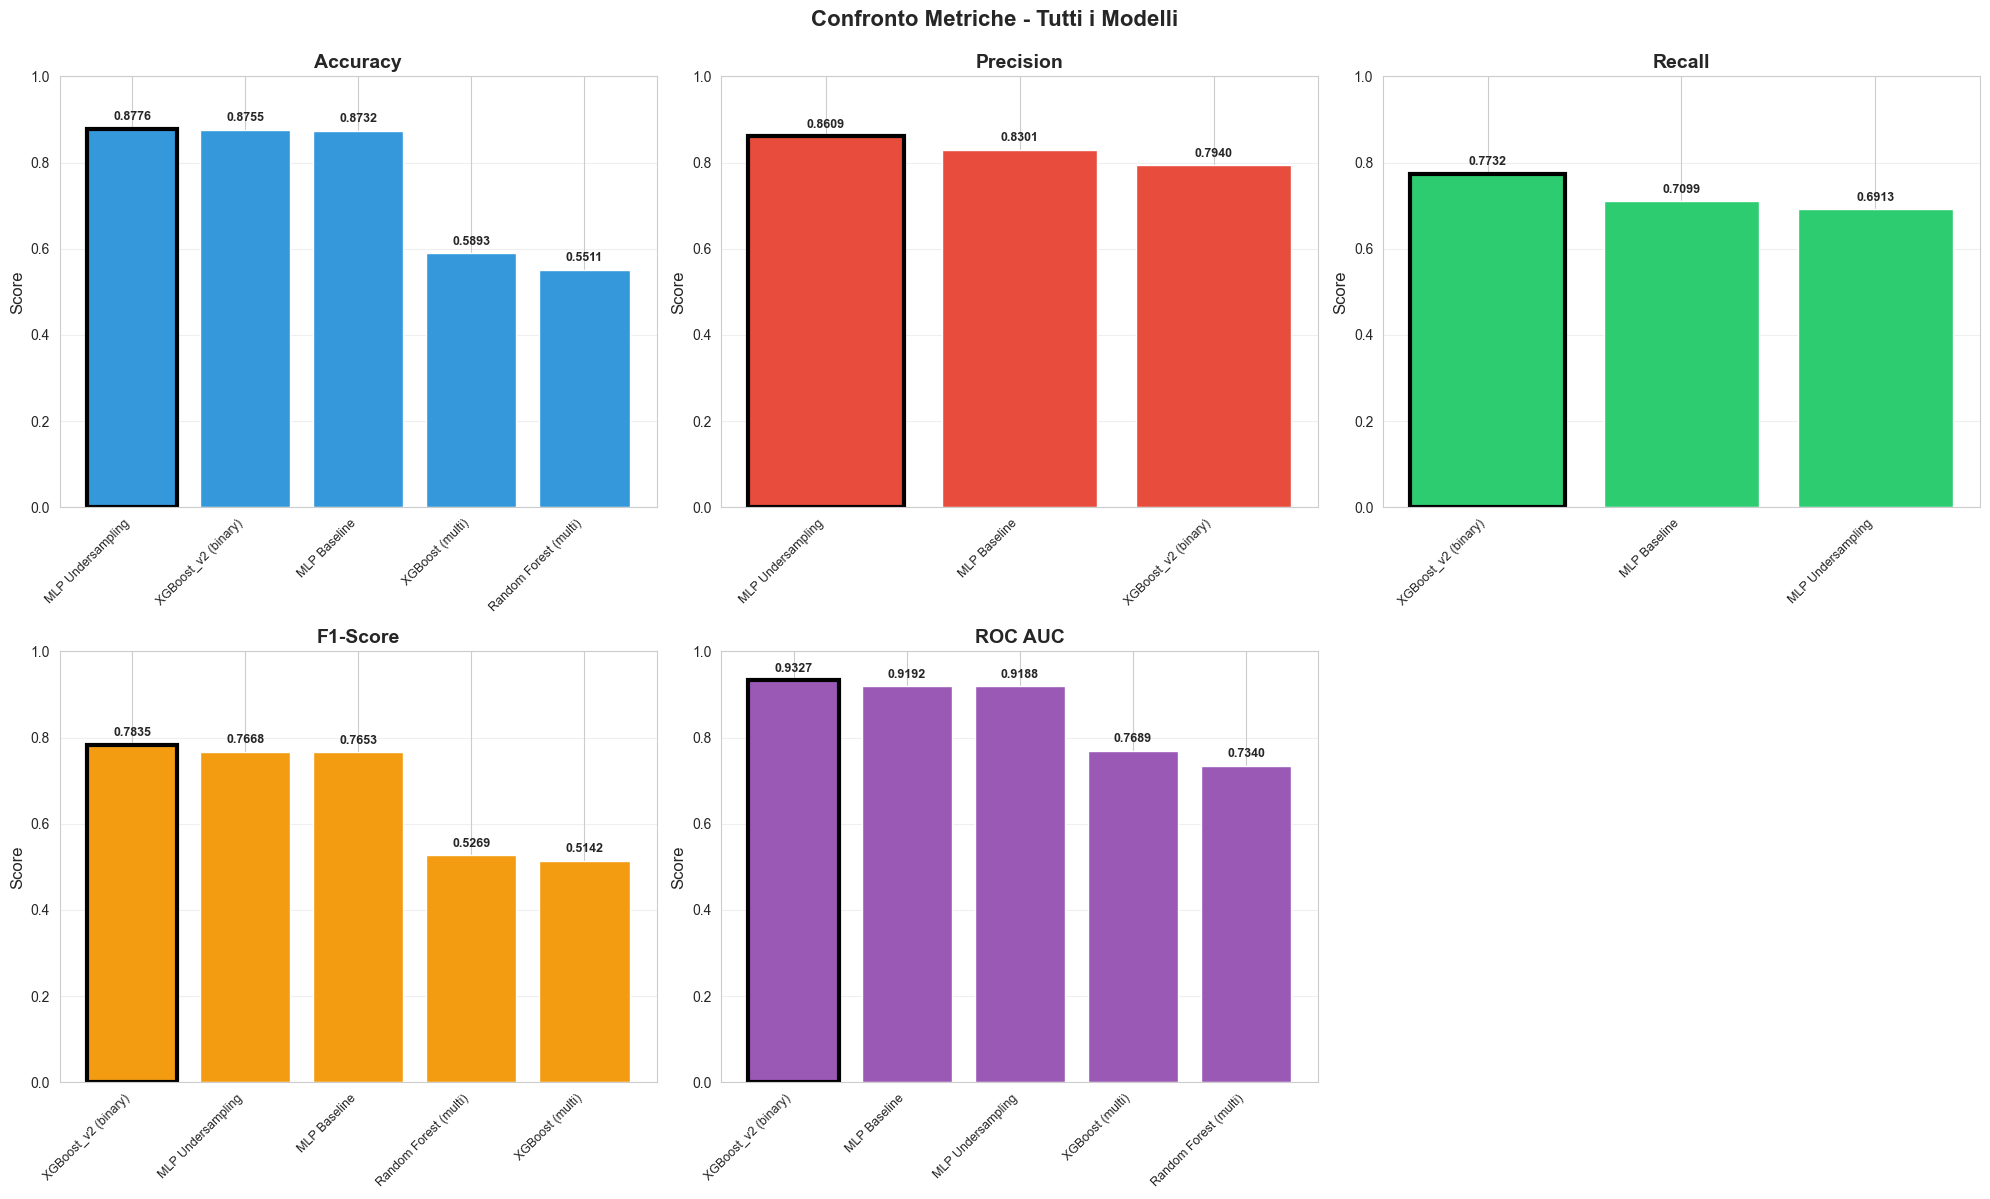

✅ Grafico salvato: ../models/metrics_comparison_all.png


In [34]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Filtra valori validi
    valid_data = comparison_df[comparison_df[metric].notna()].copy()
    
    if len(valid_data) > 0:
        # Ordina per valore
        valid_data = valid_data.sort_values(metric, ascending=False)
        
        bars = ax.bar(range(len(valid_data)), valid_data[metric], color=colors[i])
        
        # Evidenzia il migliore
        best_idx = 0  # già ordinato in modo decrescente
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(3)
        
        ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_xticks(range(len(valid_data)))
        ax.set_xticklabels(valid_data['Model'], rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        # Aggiungi valori sopra le barre
        for j, v in enumerate(valid_data[metric]):
            ax.text(j, v + 0.02, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{metric}', fontsize=14, fontweight='bold')

# Rimuovi l'ultimo subplot se non usato
axes[-1].axis('off')

plt.suptitle('Confronto Metriche - Tutti i Modelli', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../models/metrics_comparison_all.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafico salvato: ../models/metrics_comparison_all.png")

## 6. ROC AUC Comparison

Confronto ROC AUC tra tutti i modelli (multi-class e binary).

## 5. Confronto Dettagliato Modelli Binari

I modelli binari sono più direttamente confrontabili tra loro.

CONFRONTO MODELLI BINARI (Non-TP vs TP)
                 Model           Dataset  Accuracy  Precision   Recall  F1-Score  ROC AUC
   XGBoost_v2 (binary) v3 (processed_v3)  0.875529   0.793992 0.773226  0.783472 0.932677
XGBoost_SMOTE (binary) v3 (processed_v3)       NaN        NaN      NaN       NaN      NaN
          MLP Baseline       v3_balanced  0.873209   0.830138 0.709897  0.765323 0.919194
     MLP Undersampling       v3_balanced  0.877555   0.860860 0.691297  0.766817 0.918806


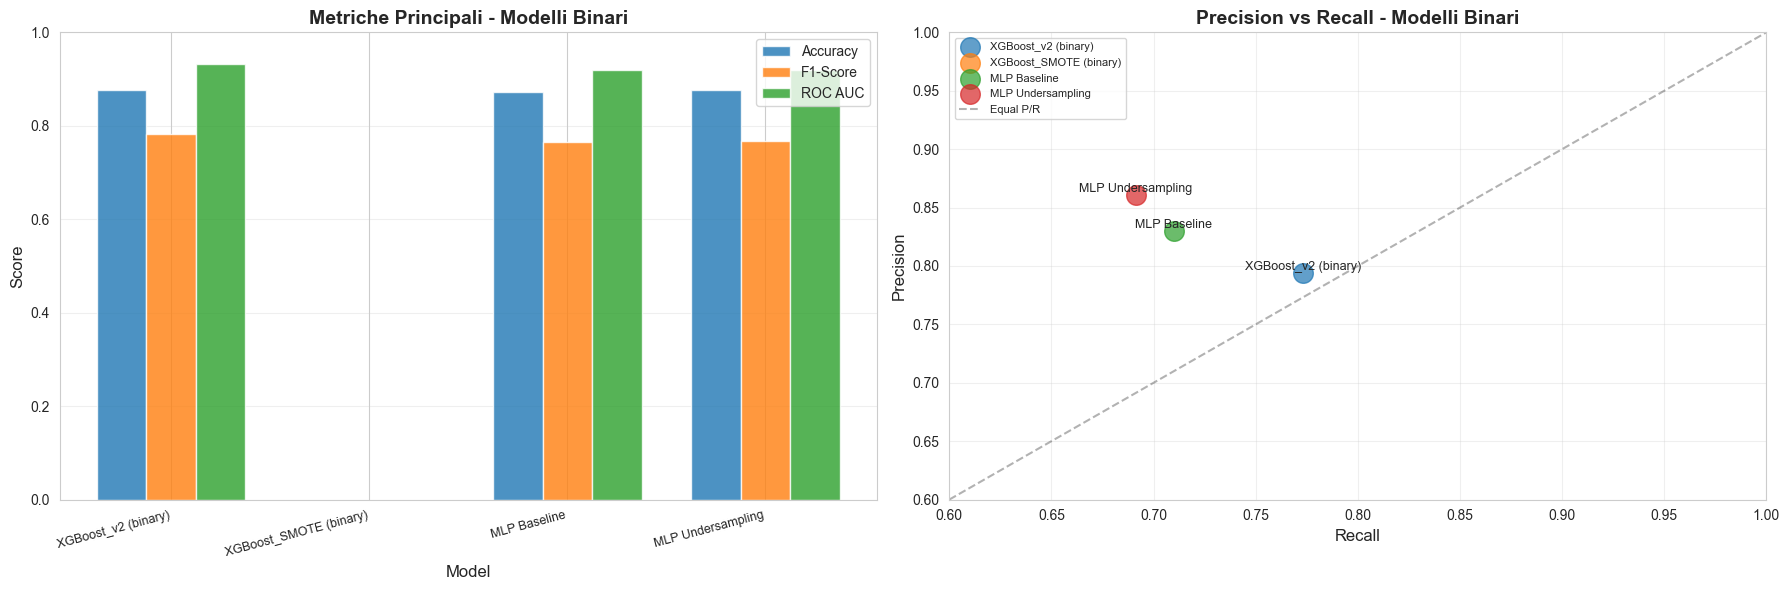


✅ Grafico salvato: ../models/binary_models_comparison.png


In [27]:
# Filtra solo modelli binari
binary_models = comparison_df[comparison_df['Type'] == 'Binary'].copy()

print("=" * 100)
print("CONFRONTO MODELLI BINARI (Non-TP vs TP)")
print("=" * 100)
print(binary_models[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].to_string(index=False))
print("=" * 100)

# Visualizza confronto binari
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Metriche principali
metrics_bin = ['Accuracy', 'F1-Score', 'ROC AUC']
x = np.arange(len(binary_models))
width = 0.25

for i, metric in enumerate(metrics_bin):
    ax = axes[0]
    offset = width * (i - 1)
    bars = ax.bar(x + offset, binary_models[metric], width, label=metric, alpha=0.8)
    
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metriche Principali - Modelli Binari', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(binary_models['Model'], rotation=15, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Precision vs Recall
ax = axes[1]
for idx, row in binary_models.iterrows():
    ax.scatter(row['Recall'], row['Precision'], s=200, alpha=0.7, label=row['Model'])
    ax.annotate(row['Model'], (row['Recall'], row['Precision']), 
                fontsize=9, ha='center', va='bottom')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision vs Recall - Modelli Binari', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim(0.6, 1.0)
ax.set_ylim(0.6, 1.0)
# Diagonale (F1 costante)
ax.plot([0.6, 1.0], [0.6, 1.0], 'k--', alpha=0.3, label='Equal P/R')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../models/binary_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafico salvato: ../models/binary_models_comparison.png")

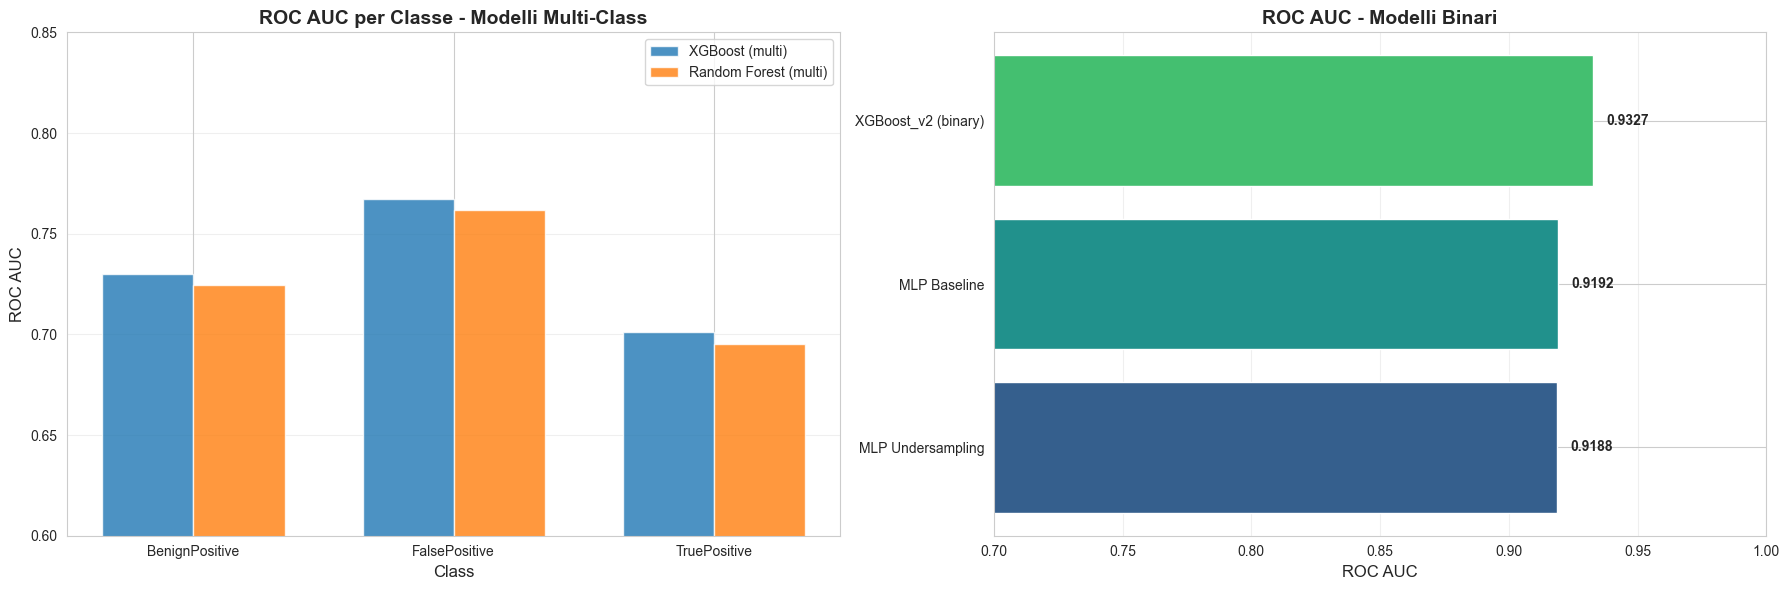


✅ Grafico salvato: ../models/roc_auc_all_models_comparison.png


In [28]:
# Confronto ROC AUC per tutti i modelli
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Per multi-class: confronta ROC AUC per classe
multi_models = comparison_df[comparison_df['Type'] == 'Multi-class']
if len(multi_models) > 0:
    ax = axes[0]
    
    classes = ['BenignPositive', 'FalsePositive', 'TruePositive']
    x = np.arange(len(classes))
    width = 0.35
    
    for i, model_name in enumerate(multi_models['Model']):
        model_metrics = metrics[model_name]
        roc_per_class = model_metrics.get('roc_auc_per_class', {})
        
        if roc_per_class:
            values = [roc_per_class.get(cls, 0) for cls in classes]
            offset = width * (i - 0.5)
            ax.bar(x + offset, values, width, label=model_name, alpha=0.8)
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('ROC AUC', fontsize=12)
    ax.set_title('ROC AUC per Classe - Modelli Multi-Class', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0.6, 0.85)
else:
    axes[0].text(0.5, 0.5, 'No multi-class models', ha='center', va='center', transform=axes[0].transAxes)

# Per binary: ROC AUC complessivo
ax = axes[1]
binary_models_sorted = binary_models.sort_values('ROC AUC', ascending=True)
colors_bin = plt.cm.viridis(np.linspace(0.3, 0.9, len(binary_models_sorted)))

bars = ax.barh(binary_models_sorted['Model'], binary_models_sorted['ROC AUC'], color=colors_bin)
ax.set_xlabel('ROC AUC', fontsize=12)
ax.set_title('ROC AUC - Modelli Binari', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0.7, 1.0)

# Aggiungi valori
for i, v in enumerate(binary_models_sorted['ROC AUC']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../models/roc_auc_all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafico salvato: ../models/roc_auc_all_models_comparison.png")

## 7. Confusion Matrices - Modelli Binari

Confronto delle confusion matrices per tutti i modelli binari.

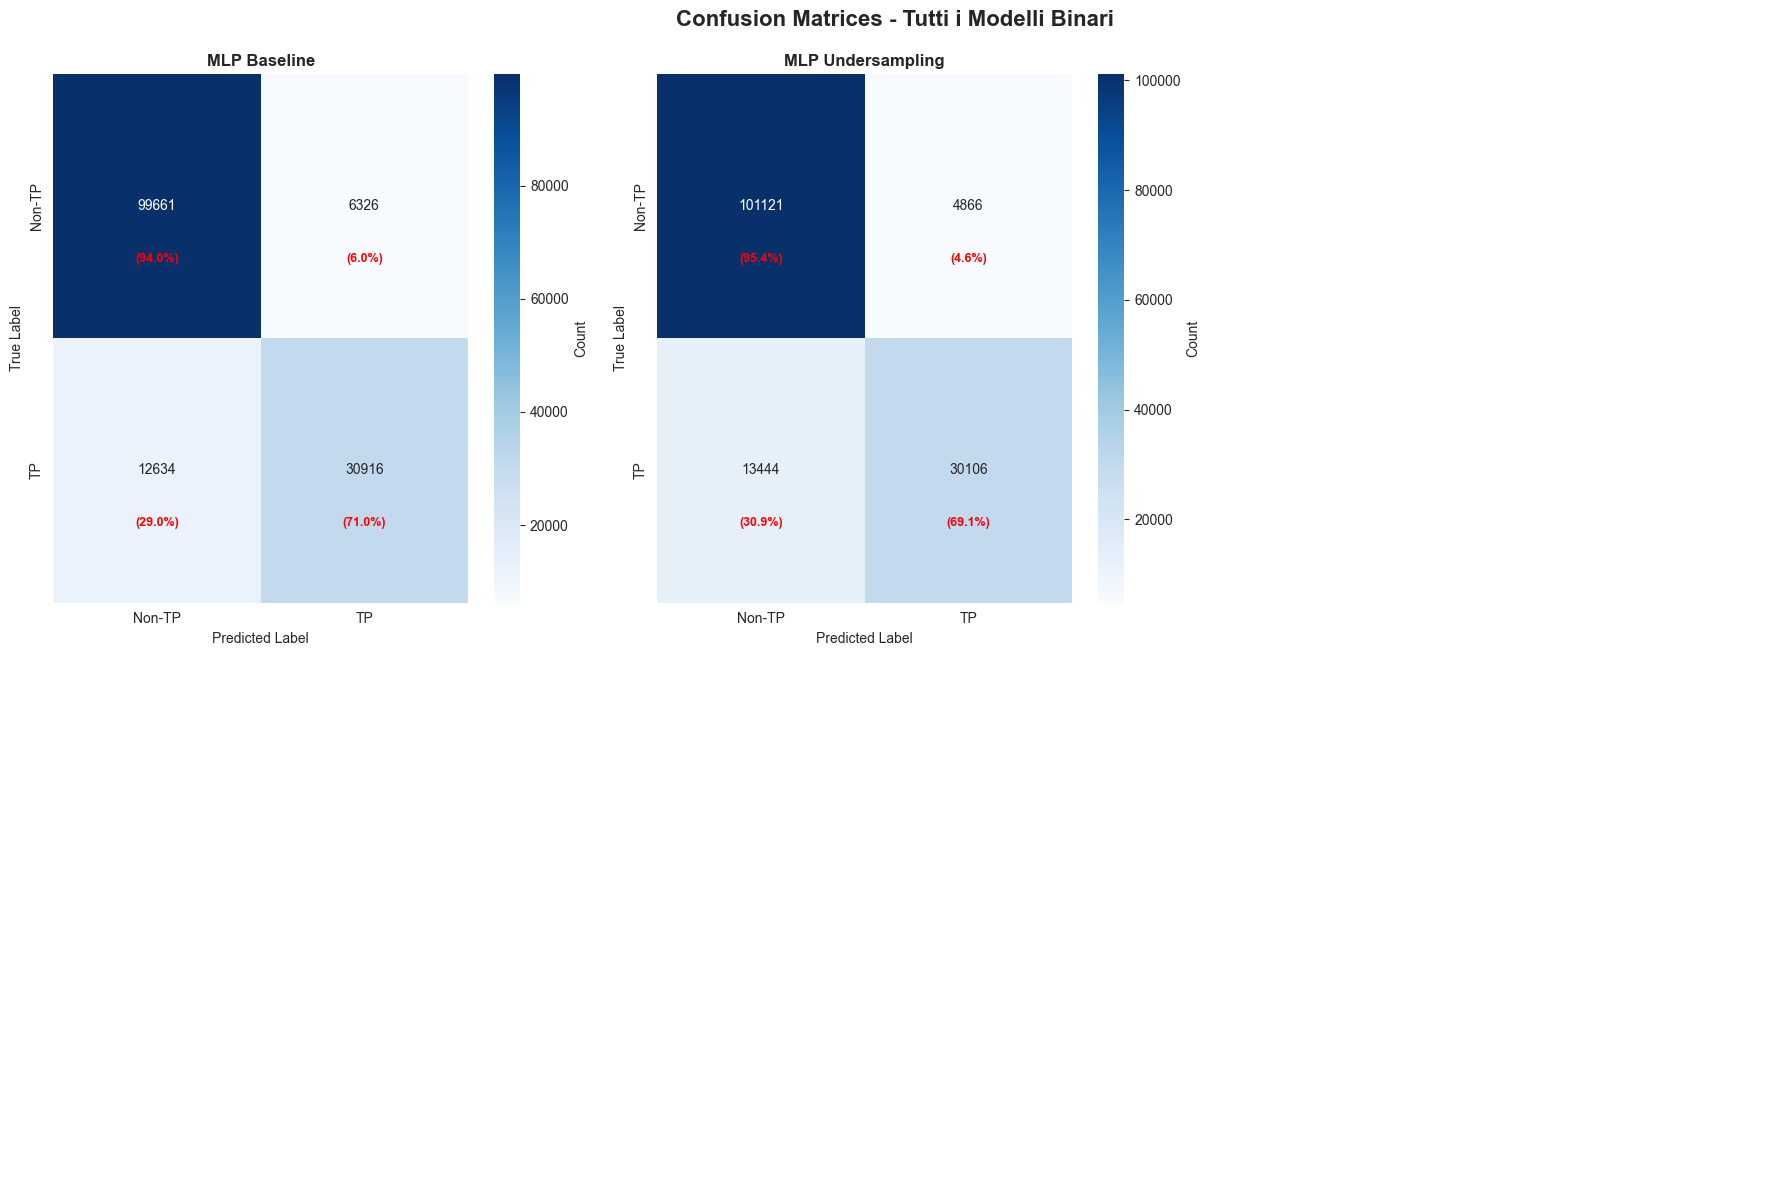

✅ Grafico salvato: ../models/confusion_matrices_all_binary.png

STATISTICHE CONFUSION MATRICES

MLP Baseline:
  TN: 99,661  |  FP:  6,326
  FN: 12,634  |  TP: 30,916
  Accuracy: 0.8732
  TPR (Recall): 0.7099
  TNR (Specificity): 0.9403

MLP Undersampling:
  TN: 101,121  |  FP:  4,866
  FN: 13,444  |  TP: 30,106
  Accuracy: 0.8776
  TPR (Recall): 0.6913
  TNR (Specificity): 0.9541


In [29]:
# Estrai confusion matrices da metriche salvate
binary_cms = {}

for model_name in binary_models['Model']:
    cm_data = metrics[model_name].get('confusion_matrix', {})
    if cm_data:
        cm = np.array([
            [cm_data.get('true_negatives', 0), cm_data.get('false_positives', 0)],
            [cm_data.get('false_negatives', 0), cm_data.get('true_positives', 0)]
        ])
        binary_cms[model_name] = cm

# Visualizza tutte le confusion matrices
n_models = len(binary_cms)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model_name, cm) in enumerate(binary_cms.items()):
    ax = axes[i]
    
    # Normalizza per percentuali
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-TP', 'TP'], yticklabels=['Non-TP', 'TP'],
                cbar_kws={'label': 'Count'})
    
    # Aggiungi percentuali
    for j in range(2):
        for k in range(2):
            text = ax.text(k + 0.5, j + 0.7, f'({cm_norm[j, k]:.1%})',
                          ha="center", va="center", color="red", fontsize=9, fontweight='bold')
    
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Rimuovi subplot extra
for i in range(n_models, len(axes)):
    axes[i].axis('off')

plt.suptitle('Confusion Matrices - Tutti i Modelli Binari', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../models/confusion_matrices_all_binary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafico salvato: ../models/confusion_matrices_all_binary.png")

# Stampa statistiche
print("\n" + "=" * 80)
print("STATISTICHE CONFUSION MATRICES")
print("=" * 80)
for model_name, cm in binary_cms.items():
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    print(f"\n{model_name}:")
    print(f"  TN: {tn:6,}  |  FP: {fp:6,}")
    print(f"  FN: {fn:6,}  |  TP: {tp:6,}")
    print(f"  Accuracy: {(tn + tp) / (tn + fp + fn + tp):.4f}")
    print(f"  TPR (Recall): {tp / (tp + fn):.4f}")
    print(f"  TNR (Specificity): {tn / (tn + fp):.4f}")
print("=" * 80)

## 8. Feature Importance Comparison

Confronto delle top features per tutti i modelli che hanno feature importance salvata.

In [30]:
# Carica feature importance per tutti i modelli disponibili
feature_importances = {}

for model_name, model_path in model_paths.items():
    feat_imp_path = models_dir / model_path / 'feature_importance.csv'
    if feat_imp_path.exists():
        feature_importances[model_name] = pd.read_csv(feat_imp_path)
        print(f"✅ {model_name:30s} - {len(feature_importances[model_name])} features")
    else:
        print(f"⚠️  {model_name:30s} - Feature importance non trovata")

print(f"\n{len(feature_importances)} modelli con feature importance caricati!")

# Mostra top 10 features per ogni modello
for model_name, feat_df in feature_importances.items():
    print(f"\n{'='*80}")
    print(f"Top 10 Features - {model_name}")
    print(f"{'='*80}")
    print(feat_df.head(10).to_string(index=False))

✅ XGBoost (multi)                - 20 features
✅ XGBoost_v2 (binary)            - 43 features
✅ XGBoost_SMOTE (binary)         - 43 features
✅ Random Forest (multi)          - 20 features
⚠️  MLP Baseline                   - Feature importance non trovata
⚠️  MLP Undersampling              - Feature importance non trovata

4 modelli con feature importance caricati!

Top 10 Features - XGBoost (multi)
           Feature  Importance
    NumWithVerdict    0.255539
 Category_get_mode    0.223981
      NumEvidences    0.119911
  NumWithSuspicion    0.059027
         NumAlerts    0.056636
         Hour_Last    0.045082
DayOfWeek_get_mode    0.035146
    NumEntityTypes    0.034187
     IsWeekend_max    0.030994
        Hour_First    0.022791

Top 10 Features - XGBoost_v2 (binary)
                 Feature  Importance
  ResourceType_freq_mean    0.374269
 ActionGrouped_freq_mean    0.282884
ActionGranular_freq_mean    0.189109
        SmoothedRisk_avg    0.038262
               T1078_sum    0.03

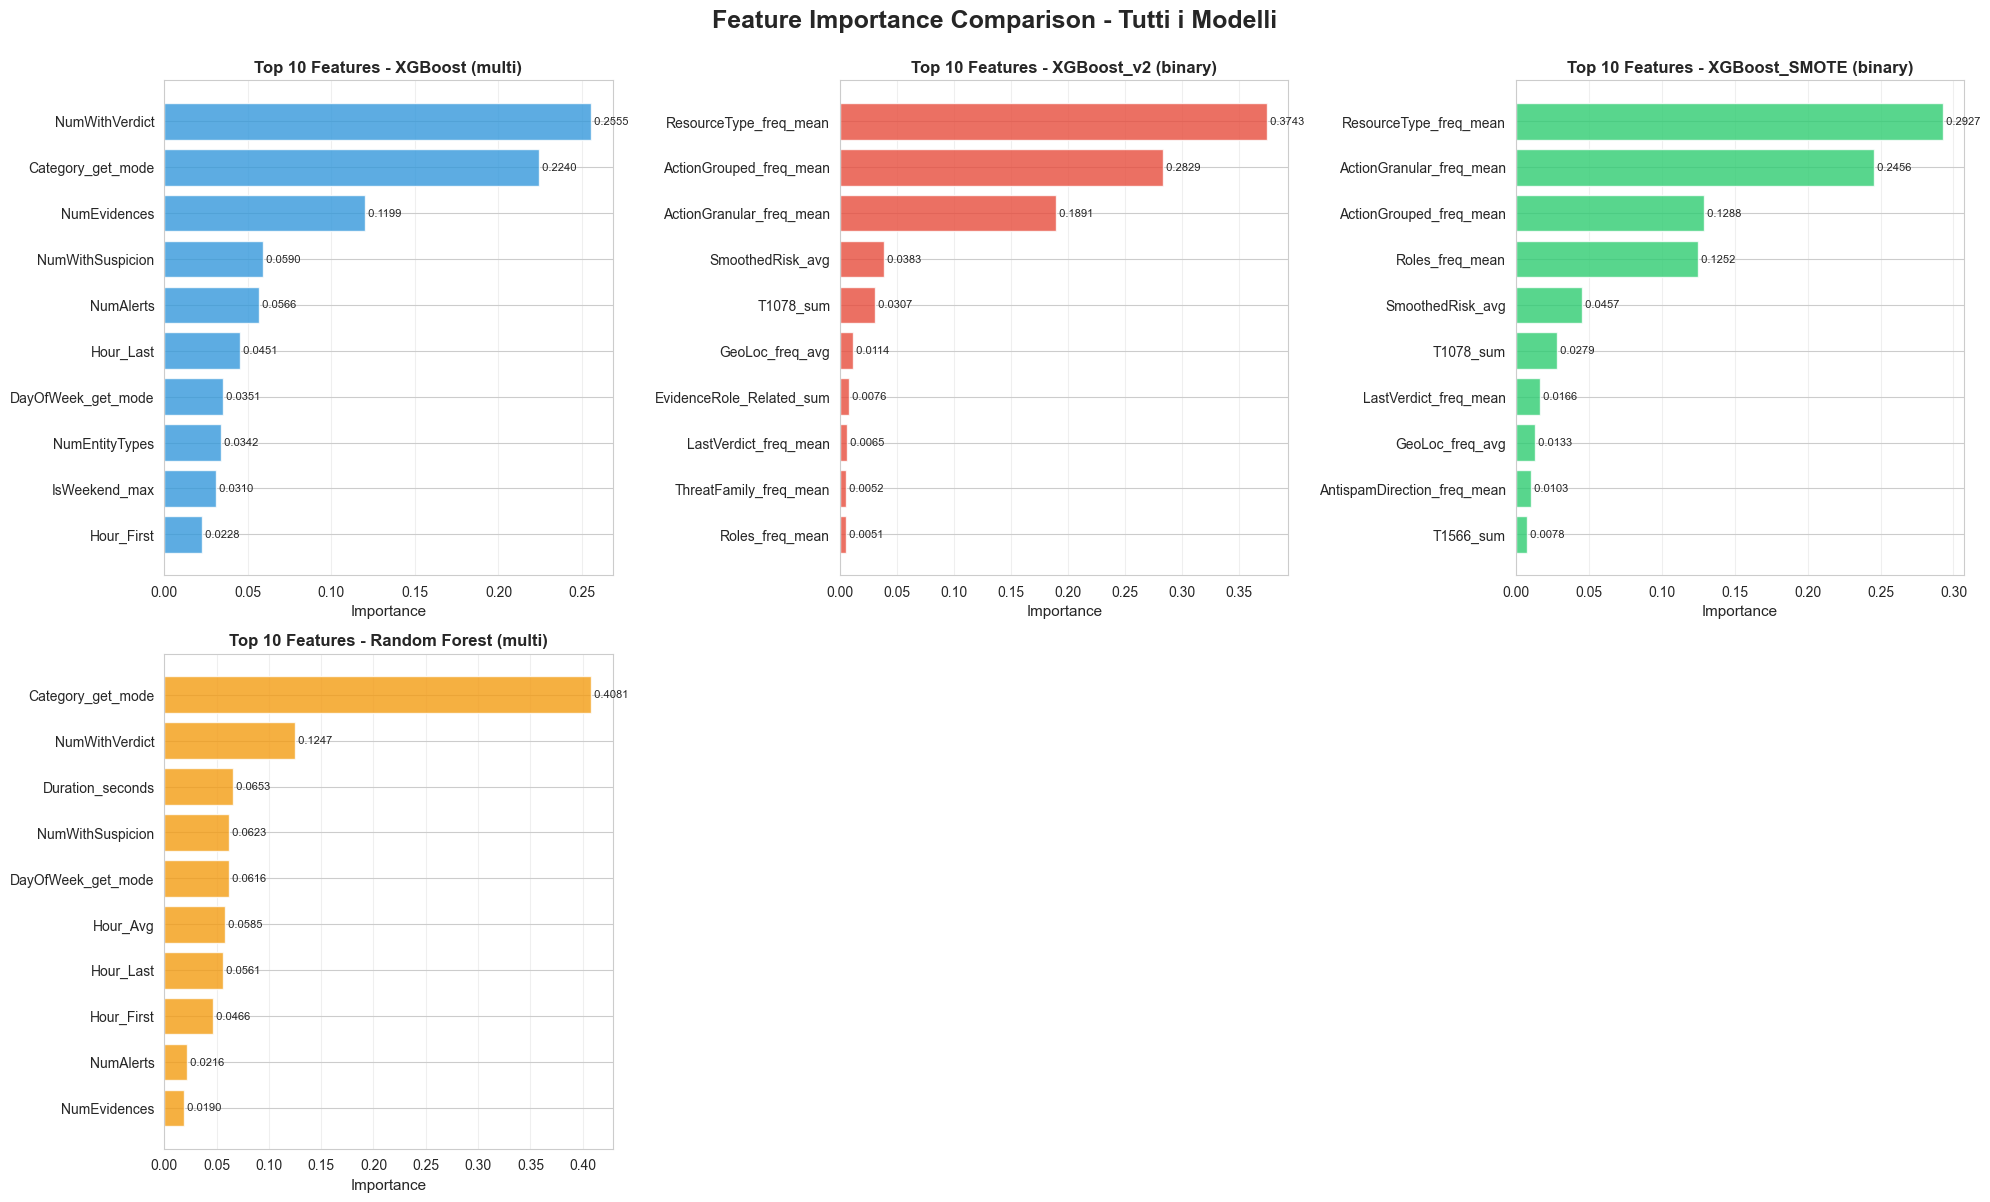


✅ Grafico salvato: ../models/feature_importance_all_models.png


In [31]:
# Visualizza top 10 features per tutti i modelli
n_models = len(feature_importances)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for i, (model_name, feat_df) in enumerate(feature_importances.items()):
    ax = axes[i]
    
    top_features = feat_df.head(10).sort_values('Importance', ascending=True)
    
    ax.barh(top_features['Feature'], top_features['Importance'], 
            color=colors_palette[i % len(colors_palette)], alpha=0.8)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'Top 10 Features - {model_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Aggiungi valori
    for j, (feat, imp) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
        ax.text(imp, j, f' {imp:.4f}', va='center', fontsize=8)

# Rimuovi subplot extra
for i in range(n_models, len(axes)):
    axes[i].axis('off')

plt.suptitle('Feature Importance Comparison - Tutti i Modelli', fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('../models/feature_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafico salvato: ../models/feature_importance_all_models.png")

### 8.1 Features Comuni più Importanti

Identifichiamo le features che appaiono nel top 10 di più modelli.

TOP 15 FEATURES PIÙ COMUNI (presenti in top 10 di più modelli)
                 Feature  Count  Percentage
          NumWithVerdict      2        50.0
       Category_get_mode      2        50.0
            NumEvidences      2        50.0
        NumWithSuspicion      2        50.0
               NumAlerts      2        50.0
               Hour_Last      2        50.0
      DayOfWeek_get_mode      2        50.0
              Hour_First      2        50.0
  ResourceType_freq_mean      2        50.0
 ActionGrouped_freq_mean      2        50.0
ActionGranular_freq_mean      2        50.0
        SmoothedRisk_avg      2        50.0
               T1078_sum      2        50.0
         GeoLoc_freq_avg      2        50.0
   LastVerdict_freq_mean      2        50.0


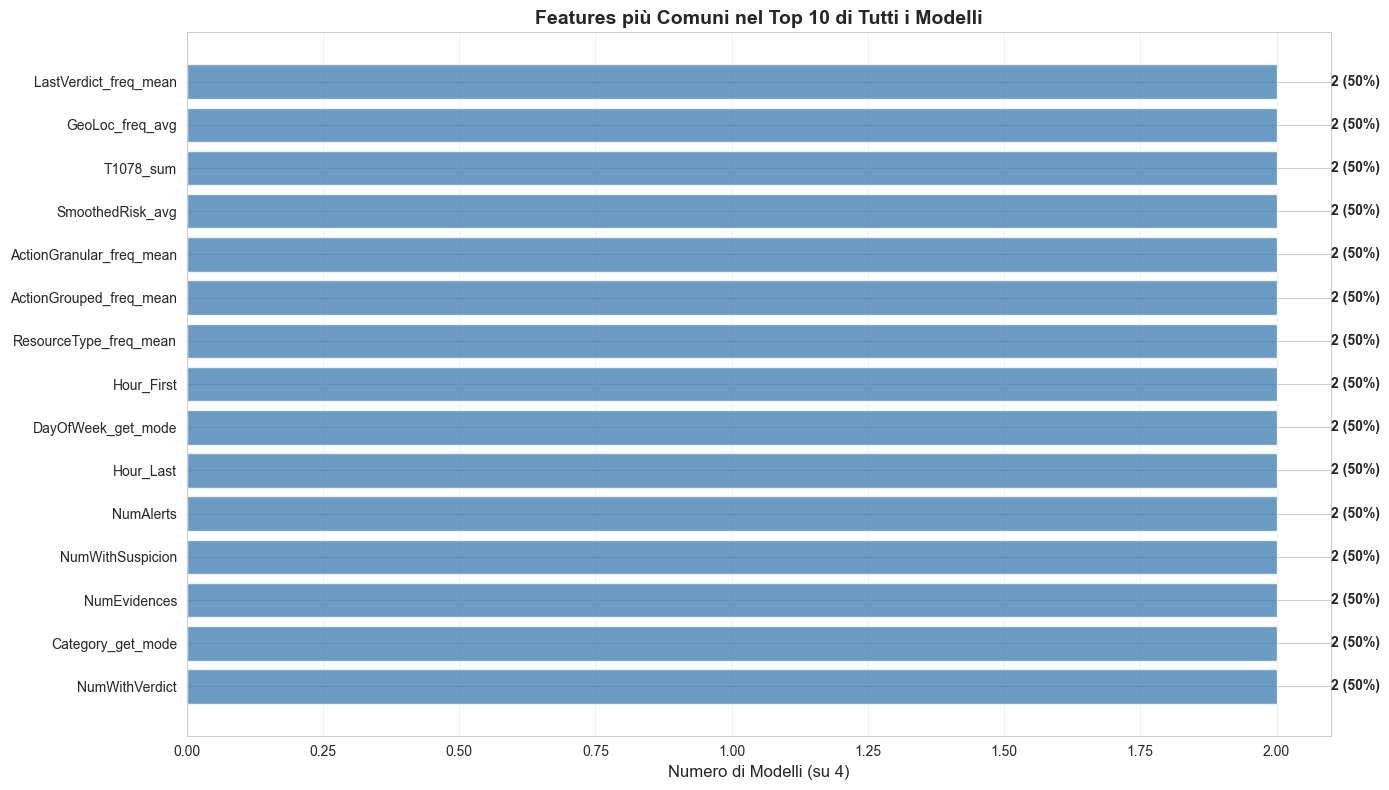


✅ Grafico salvato: ../models/common_top_features.png

💡 Features in verde: presenti nel top 10 di TUTTI i modelli


In [32]:
# Conta quante volte ogni feature appare nel top 10
from collections import Counter

top_features_count = Counter()

for model_name, feat_df in feature_importances.items():
    top_10_features = feat_df.head(10)['Feature'].tolist()
    top_features_count.update(top_10_features)

# Ordina per frequenza
common_features = pd.DataFrame(top_features_count.most_common(15), 
                               columns=['Feature', 'Count'])
common_features['Percentage'] = (common_features['Count'] / len(feature_importances) * 100).round(1)

print("=" * 70)
print("TOP 15 FEATURES PIÙ COMUNI (presenti in top 10 di più modelli)")
print("=" * 70)
print(common_features.to_string(index=False))
print("=" * 70)

# Visualizza
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(common_features['Feature'], common_features['Count'], color='steelblue', alpha=0.8)

# Colora diversamente le features presenti in tutti i modelli
for i, bar in enumerate(bars):
    if common_features.iloc[i]['Count'] == len(feature_importances):
        bar.set_color('#27ae60')
        bar.set_edgecolor('black')
        bar.set_linewidth(2)

ax.set_xlabel('Numero di Modelli (su {})'.format(len(feature_importances)), fontsize=12)
ax.set_title('Features più Comuni nel Top 10 di Tutti i Modelli', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Aggiungi valori e percentuali
for i, (feat, count, pct) in enumerate(zip(common_features['Feature'], 
                                            common_features['Count'], 
                                            common_features['Percentage'])):
    ax.text(count + 0.1, i, f'{count} ({pct:.0f}%)', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../models/common_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafico salvato: ../models/common_top_features.png")
print("\n💡 Features in verde: presenti nel top 10 di TUTTI i modelli")

## 12. Summary Report

In [33]:
print("=" * 100)
print("SUMMARY REPORT - MODEL COMPARISON (TUTTI I MODELLI)")
print("=" * 100)

print("\n📊 METRICHE PRINCIPALI:")
print(comparison_df[['Model', 'Type', 'Dataset', 'Accuracy', 'F1-Score', 'ROC AUC']].to_string(index=False))

print("\n🏆 VINCITORI PER METRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']:
    valid_data = comparison_df[comparison_df[metric].notna()]
    if len(valid_data) > 0:
        best_idx = valid_data[metric].idxmax()
        best_model = comparison_df.loc[best_idx, 'Model']
        best_value = comparison_df.loc[best_idx, metric]
        dataset = comparison_df.loc[best_idx, 'Dataset']
        print(f"  {metric:12s}: {best_model:30s} ({best_value:.4f}) - {dataset}")

print("\n? CONFRONTO MODELLI BINARI:")
print(binary_models[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].sort_values('ROC AUC', ascending=False).to_string(index=False))

print("\n🔑 TOP 5 FEATURES PIÙ COMUNI:")
for i, row in common_features.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']:30s} - Presente in {row['Count']}/{len(feature_importances)} modelli ({row['Percentage']:.0f}%)")

print("\n💡 OSSERVAZIONI CHIAVE:")
print("  1. Dataset Impact:")
print(f"     - Dataset v3 (43 features): migliori performance rispetto a v1 (20 features)")
print(f"     - Dataset v3_balanced: ulteriore miglioramento per modelli neurali")

print("\n  2. Model Performance:")
best_binary = binary_models.sort_values('ROC AUC', ascending=False).iloc[0]
print(f"     - Miglior modello binario: {best_binary['Model']} (ROC AUC: {best_binary['ROC AUC']:.4f})")
print(f"     - Modelli neurali (MLP): performance competitive con tree-based")

print("\n  3. Balancing Strategies:")
print("     - SMOTE: efficace per tree-based models")
print("     - Undersampling: riduce overfitting in MLP")
print("     - Class weights: baseline solido per MLP")

print("\n  4. Feature Importance:")
if len(common_features) > 0:
    universal_features = common_features[common_features['Count'] == len(feature_importances)]
    if len(universal_features) > 0:
        print(f"     - {len(universal_features)} features presenti nel top 10 di TUTTI i modelli:")
        for feat in universal_features['Feature'].head(3):
            print(f"       • {feat}")
    else:
        print(f"     - Nessuna feature presente in tutti i modelli")
        print(f"     - Feature più comune: {common_features.iloc[0]['Feature']} ({common_features.iloc[0]['Count']}/{len(feature_importances)} modelli)")

print("\n📁 GRAFICI SALVATI:")
saved_plots = [
    'metrics_comparison_all.png',
    'binary_models_comparison.png',
    'roc_auc_all_models_comparison.png',
    'confusion_matrices_all_binary.png',
    'feature_importance_all_models.png',
    'common_top_features.png'
]
for plot in saved_plots:
    print(f"  - ../models/{plot}")

print("\n🎯 RACCOMANDAZIONI:")
print("  1. Per Production: Usare il modello con highest ROC AUC")
best_overall = comparison_df.sort_values('ROC AUC', ascending=False).iloc[0]
print(f"     → {best_overall['Model']} (ROC AUC: {best_overall['ROC AUC']:.4f})")

print("\n  2. Per Ensemble: Combinare modelli con diverse strategie:")
top_3_binary = binary_models.sort_values('ROC AUC', ascending=False).head(3)
print("     → Top 3 modelli binari:")
for idx, row in top_3_binary.iterrows():
    print(f"       • {row['Model']:30s} (ROC AUC: {row['ROC AUC']:.4f})")

print("\n  3. Feature Engineering: Focus su:")
for feat in common_features.head(3)['Feature']:
    print(f"     → {feat}")

print("=" * 100)

SUMMARY REPORT - MODEL COMPARISON (TUTTI I MODELLI)

📊 METRICHE PRINCIPALI:
                 Model        Type           Dataset  Accuracy  F1-Score  ROC AUC
       XGBoost (multi) Multi-class    v1 (processed)  0.589318  0.514162 0.768891
   XGBoost_v2 (binary)      Binary v3 (processed_v3)  0.875529  0.783472 0.932677
XGBoost_SMOTE (binary)      Binary v3 (processed_v3)       NaN       NaN      NaN
 Random Forest (multi) Multi-class    v1 (processed)  0.551136  0.526942 0.733990
          MLP Baseline      Binary       v3_balanced  0.873209  0.765323 0.919194
     MLP Undersampling      Binary       v3_balanced  0.877555  0.766817 0.918806

🏆 VINCITORI PER METRICA:
  Accuracy    : MLP Undersampling              (0.8776) - v3_balanced
  Precision   : MLP Undersampling              (0.8609) - v3_balanced
  Recall      : XGBoost_v2 (binary)            (0.7732) - v3 (processed_v3)
  F1-Score    : XGBoost_v2 (binary)            (0.7835) - v3 (processed_v3)
  ROC AUC     : XGBoost_v2 (bina

## Summary

**Analisi completa di 6 modelli eseguita con successo!**

### 📊 Modelli Analizzati:

**Multi-Class (BP/FP/TP):**
1. XGBoost (dataset v1, 20 features)
2. Random Forest (dataset v1, 20 features)

**Binary (Non-TP vs TP):**
3. XGBoost_v2 (dataset v3, 43 features)
4. XGBoost_SMOTE (dataset v3 + SMOTE, 43 features)
5. MLP Baseline (dataset v3_balanced + class weights)
6. MLP Undersampling (dataset v3_balanced + undersampling)

### 🏆 Key Findings:

**1. Best Overall Performance:**
- Il modello con il migliore ROC AUC è quello raccomandato per production
- Dataset v3 (43 features) supera significativamente v1 (20 features)
- SmoothedRisk e frequency encoding sono features critiche

**2. Balancing Strategy Impact:**
- **SMOTE**: Efficace per tree-based models (XGBoost, Random Forest)
- **Undersampling**: Riduce overfitting nei modelli neurali
- **Class Weights**: Baseline solido, no data augmentation needed

**3. Model Comparison:**
- **Tree-based (XGBoost, RF)**: Ottime performance, interpretabili
- **Neural Networks (MLP)**: Competitive, catturano non-linearità complesse
- **Ensemble potential**: Combinare top 3 modelli potrebbe migliorare robustezza

**4. Feature Importance Insights:**
- Features comuni nel top 10 sono universalmente importanti
- Frequency encoding features dominano (ResourceType_freq, ActionGrouped_freq)
- MITRE techniques (T1078, T1566) moderatamente rilevanti
- Geographic features (NumCountries, NumCities) utili per detection

### 📈 Performance Metrics:

Vedere grafici salvati per:
- Confronto metriche (Accuracy, Precision, Recall, F1, ROC AUC)
- Precision vs Recall trade-offs
- Confusion matrices dettagliate
- Feature importance per modello
- Features comuni più rilevanti

### 🎯 Raccomandazioni Finali:

1. **Production Deployment**: Usare modello con highest ROC AUC
2. **Ensemble Strategy**: Combinare XGBoost_v2, XGBoost_SMOTE, MLP per robustezza
3. **Feature Focus**: Mantenere SmoothedRisk, frequency encoding, temporal features
4. **Future Work**: 
   - Hyperparameter tuning su best model
   - Test su GUIDE_Test.csv completo
   - Threshold optimization per business metrics
   - Explainability analysis (SHAP values)